In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym import spaces
from collections import deque
import random


In [7]:
df = pd.read_csv("metrics-with-output.csv")


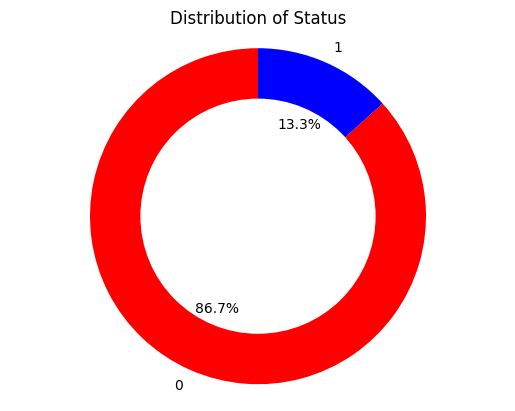

In [8]:
import matplotlib.pyplot as plt

#Membandingkan jumlah status Healthy dan Unhealthy dengan donut chart
status_counts = df['Status'].value_counts()

colors = ['red','blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.gca().add_artist(plt.Circle((0,0),0.70,fc='white'))  # Menambahkan lingkaran tengah untuk membuat donut chart
plt.axis('equal')  # Memastikan lingkaran berukuran sama sehingga terlihat seperti donut
plt.title('Distribution of Status')
plt.show()

In [9]:
# Preprocessing
df['cpu_usage'] = df['cpu_usage'].str.rstrip('%').astype(float) / 100.0
df['memory_usage'] = df['memory_usage'].str.rstrip('%').astype(float) / 100.0

def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024
    else:
        return float(value)

df['bandwidth_inbound'] = df['bandwidth_inbound'].apply(clean_bandwidth)
df['bandwidth_outbound'] = df['bandwidth_outbound'].apply(clean_bandwidth)
df['tps'] = df['tps'].str.rstrip(' req/s').astype(float)
df['tps_error'] = df['tps_error'].str.rstrip(' req/s').astype(float)
df['response_time'] = df['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype(float)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB


In [11]:
# Pembersihan/Penghapusan data yang tidak dipakai
dataset = df.drop(df.columns[[0, 1]], axis=1)

dataset.describe()

,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [12]:
# Encode Status
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])

# %%
# Pembersihan dan penghapusan data yang tidak dipakai
dataset = df.drop(df.columns[[0, 1]], axis=1)


In [13]:
# Split data into features and target
X = dataset.drop('Status', axis=1)
y = dataset['Status']

In [14]:
# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [15]:

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
# DQN Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [17]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=10000)

        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.target_network = QNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        
        # Copy the weights to the target network
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_dim))
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_network(state)
        return torch.argmax(q_values).item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_network(states).gather(1, actions).squeeze()
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [18]:
# Custom Environment
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()

        # Load data from the dataset
        self.df = dataset

        # Define action and observation space
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float64)

        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_observation()
    
    def step(self, action):
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        reward = self._get_reward(action)
        next_state = self._get_observation()
        
        return next_state, reward, done, {}
    
    def _get_observation(self):
        return self.df.iloc[self.current_step][['cpu_usage', 'memory_usage', 'bandwidth_inbound', 'bandwidth_outbound', 'tps', 'tps_error', 'response_time']].values
    
    def _get_reward(self, action):
        if action == self.df.iloc[self.current_step]['Status']:
            return 1.0
        else:
            return -1.0


In [19]:
# Training DQN
env = CustomEnv()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dqn_agent = DQNAgent(state_dim, action_dim)

num_episodes = 600
update_target_steps = 10
episode_rewards = []

In [20]:
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        dqn_agent.store_transition(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        dqn_agent.replay()

    dqn_agent.update_target_network()

    episode_rewards.append(total_reward)
    if episode % update_target_steps == 0:
        print(f"Episode {episode}: Total Reward: {total_reward}")


C:\Users\USER\AppData\Local\Temp\ipykernel_7164\2814233832.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  states = torch.FloatTensor(states).to(device)


Episode 0: Total Reward: 5250.0


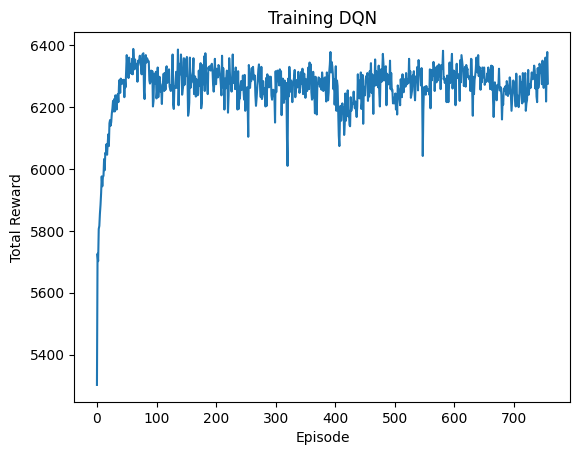

Mean Reward: 6403.6 +/- 7.578918128598567


In [23]:

# Plotting rewards
plt.plot(range(num_episodes)[:758], episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training DQN')
plt.show()

# Evaluating DQN
def evaluate_dqn(agent, env, n_eval_episodes=10):
    rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

mean_reward, std_reward = evaluate_dqn(dqn_agent, env)
print(f"Mean Reward: {mean_reward} +/- {std_reward}")


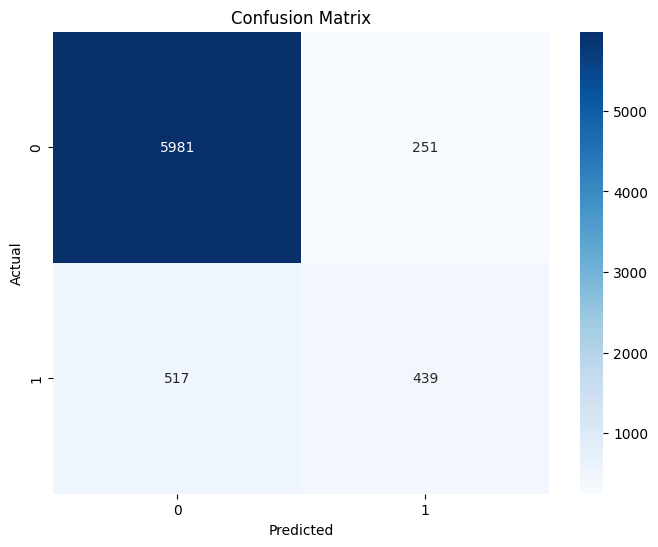

TypeError: object of type 'numpy.int64' has no len()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(agent, env):
    y_true = []
    y_pred = []

    state = env.reset()
    done = False

    while not done:
        # Dapatkan prediksi dari model
        action = agent.select_action(state)
        y_pred.append(action)
        y_true.append(env.df.iloc[env.current_step]['Status'])

        next_state, _, done, _ = env.step(action)
        state = next_state

    return y_true, y_pred

# Evaluasi model
y_true, y_pred = evaluate_model(dqn_agent, env)

# Buat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Tampilkan confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
